## OVERVIEW
---
* Classifying Gender voice by Constructing a Machine learning model.
* Constructing a function that can generate a Receiver Operating Characteristic (ROC) curve.
* Comparison of Predictive models.

In [1]:
#data manipulation and visualization library
import numpy as np
import pandas as pd
import matplotlib.patches as patches
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_style('whitegrid')

#predictive models
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/voice_dataset.csv')
print('Dataframe Shape: ', df.shape)

Dataframe Shape:  (3168, 21)


### DATA BASIC INFORMATION
---

In [3]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [4]:
df.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')

In [5]:
#get the frequency of labels
df.groupby('label').size()

label
female    1584
male      1584
dtype: int64

* The data is balanced, both male and female have the same frequency on our data.

In [6]:
#check the statistical data
df.groupby('label').describe()

meanfreq                                                              \
          count      mean       std       min       25%       50%       75%   
label                                                                         
female   1584.0  0.191000  0.029960  0.078847  0.177031  0.192732  0.211981   
male     1584.0  0.170813  0.026254  0.039363  0.155625  0.176343  0.190593   

                      sd            ...  dfrange            modindx            \
             max   count      mean  ...      75%        max   count      mean   
label                               ...                                         
female  0.251124  1584.0  0.049142  ...  8.53125  21.773438  1584.0  0.170073   
male    0.225582  1584.0  0.065110  ...  6.00000  21.843750  1584.0  0.177430   

                                                               
             std  min       25%       50%       75%       max  
label                                                          
female  0.107639  0.0  0.101201  0.138995  0.201557  0.857764  
male    0.130132  0.0  0.099184  0.139904  0.212205  0.932374  

[2 rows x 160 columns]

In [7]:
#check the feature data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
meanfreq    3168 non-null float64
sd          3168 non-null float64
median      3168 non-null float64
Q25         3168 non-null float64
Q75         3168 non-null float64
IQR         3168 non-null float64
skew        3168 non-null float64
kurt        3168 non-null float64
sp.ent      3168 non-null float64
sfm         3168 non-null float64
mode        3168 non-null float64
centroid    3168 non-null float64
meanfun     3168 non-null float64
minfun      3168 non-null float64
maxfun      3168 non-null float64
meandom     3168 non-null float64
mindom      3168 non-null float64
maxdom      3168 non-null float64
dfrange     3168 non-null float64
modindx     3168 non-null float64
label       3168 non-null object
dtypes: float64(20), object(1)
memory usage: 519.9+ KB


* No null values on the dataset and all the features except the target are already on numerical form.

### DATA PREPARATION
---

In [8]:
#label encode the target
le = LabelEncoder()
labels = le.fit_transform(df.label)
df['label'] = labels

In [9]:
#split the features and labels
X = df.drop('label', axis=1)
y = df.label

#### FUNCTION THAT CAN GENERATE A  ROC CURVE

In [10]:
def plot_roc(X, y, estemeator,n_splits, lns = 100):
    #creating an instance of KFold
    kfold = StratifiedKFold(n_splits=n_splits,shuffle=False)
    #define estemator
    rf = estemeator
    #deifne figuresize
    plt.rcParams['figure.figsize'] = (10,5)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,lns)
    i = 1

    for train,test in kfold.split(X,y):
        #get prediction
        prediction = rf.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
        #get the true pos. rate, false positive rate and thresh 
        fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        #get the area under the curve
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #plot the tpr and fpr
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

    #plot the mean ROC
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='gold',
    label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

    #setup the labels
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title('ROC PLOT', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)


* I used KFold to shuffle the data, to visualize other posibilities that can occur during training.

## MACHINE LEARNING
---

### RANDOM FOREST CLASSIFIER
---

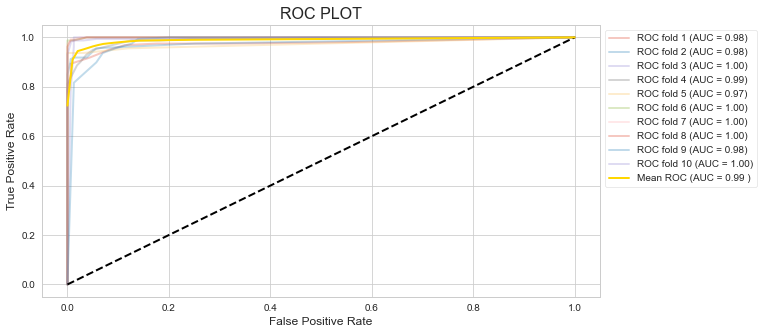

In [11]:
rf = RandomForestClassifier(random_state=101)
#plot the roc curve
plot_roc(X, y, estemeator=rf, n_splits=10, lns=100)

### LOGISTIC REGRESSION
---

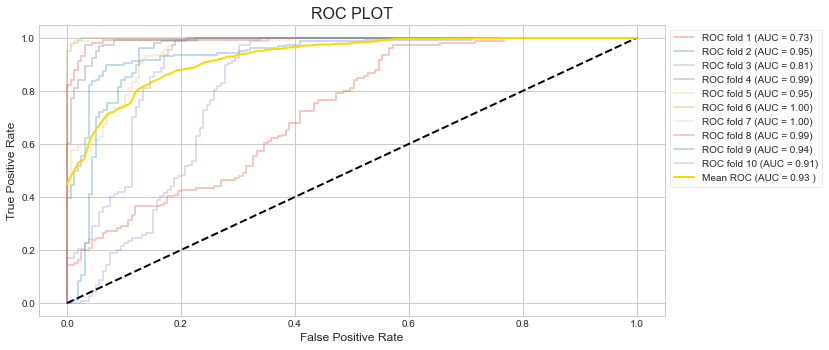

In [93]:
lg = LogisticRegression( n_jobs=5, random_state=101)
#plot the roc 
plot_roc(X, y, lg, n_splits=10, lns=100)

* Logistic Regression model is not stable, AUC of fold 1 and fold 2 are low compared to the others.

### MULTINOMIAL NAIVE BAYES
---

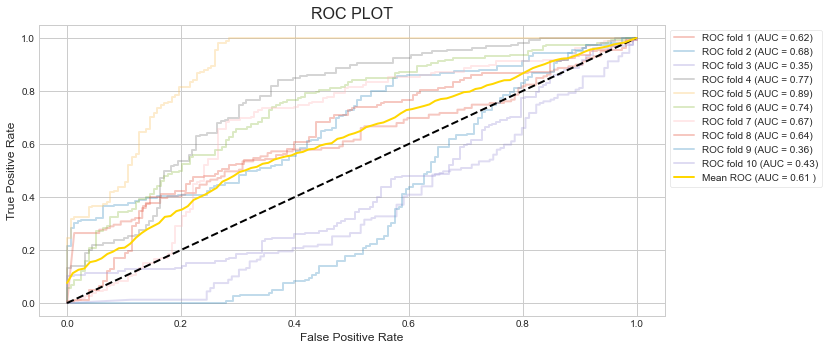

In [94]:
mn = MultinomialNB()
#plot the roc curve of the model
plot_roc(X, y, mn, n_splits=10, lns=100)

* MultomialNB performed much worse than our Logistic Regression model, Mean ROC is pretty low here.

### SUPPORT VECTOR CLASSIFIER
---

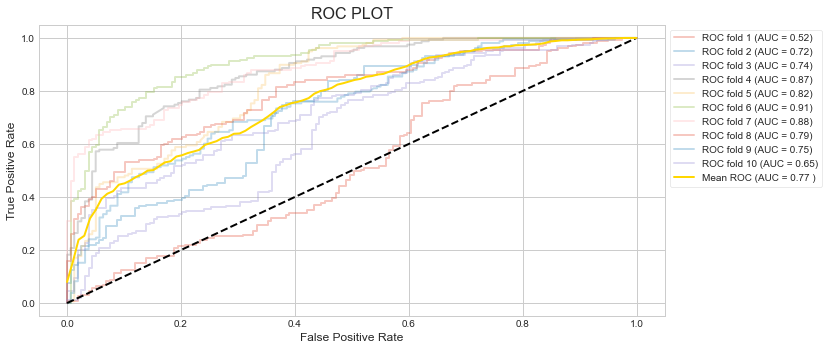

In [96]:
svc = SVC(probability=True)
#plot the roc curve
plot_roc(X, y, svc, n_splits=10, lns=100)

* SVC results are average, Because the hyperparameters are the defaults.

### INSIGHTS
---
* RandomForest Classifier outperform most of the models here, but SVC can be further improve by applying RandomSearchCV to give its right parameters.
